# This notebook contains:
* Code to regrid himawari-8 brightness temperature
* Code to make hovmöller plots for Townsville for radar reflectivity and himawari-8 channel 13 brightness temperature

In [1]:
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
import os
# import xesmf as xe
from datetime import datetime
import seaborn as sns
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import geopandas as gpd
import dask


In [2]:
# plot gbr locations
GBR_loc_fp = '/home/563/ac9768/GBR/Aus_Bathymetry/GBR_reef_locations.txt'# Lists to store latitude and longitude pairs
latitudes = []
longitudes = []

# Open the file and read line by line
with open(GBR_loc_fp, 'r') as file:
    for line in file:
        # Split each line into latitude and longitude
        values = line.split()
        if len(values) == 2:  # Ensure there are exactly two values on each line
            latitude, longitude = map(float, values)
            latitudes.append(latitude)
            longitudes.append(longitude)

# make an array which lists (lon,lat) reef coordinates
latitudes_array = np.array(latitudes)
longitudes_array = np.array(longitudes)
gbr_coordinates = np.column_stack((longitudes,latitudes))

In [3]:
def path_to_radar_ds(radar_site_no: str):
    """Create list of file paths for the chosen radar ID.
    List selects JFMA data between 2012-01 and 2022-04

    Args:
        radar_site_no (str): String of radar ID number; cairns = "19", willis island = "41"

    Returns:
        list: List of file paths strings
    """
    list = ["202201","202202","202203","202204","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] 
    files_list = []
    for i in list:
        fp = "/g/data/rq0/admin/level_2_decomissioned_fields/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list

In [19]:
def radar_ds(file_list: list):
    """Open radar dataset, apply quality control mask

    Args:
        file_list (list): list of radar files to take subset

    Returns:
        xr.Dataset: Rain rate dataset
    """    
    def _preprocess(ds):
        # Apply quality control
        ds = ds.where(ds.isfile == 1)
        return ds.rainrate
    
    return xr.open_mfdataset(
        file_list,
        preprocess=_preprocess,
        parallel=True, 
        combine="by_coords")

In [21]:
def mask_radar_data(file_list: list, cairns: bool = None):
    """Mask subset rain rate dataset 
    1. Open subset data twice
    - mean_ds is used to find invalid points (where no measurements are taken)
    - ds is used to fill all nans as zeroes (where no rainfall is measured --> set to zero instead of nan)
    2. Apply masks 

    Args:
        file_list (list): List of file paths strings
        cairns (bool): Defaults to None. It true, beam blockage mask is also applied to the final dataset

    Returns:
        xr.Dataset: Xarray dataset of mean rain rate across the narrow latitude slice for each time step (with masks applied)
    """
    ds = radar_ds(file_list)
    mean_ds = radar_ds(file_list)

    # 1a. Identify regions where rainrate is *always* NaN (i.e., no measurements ever)
    valid_mask = mean_ds.rainrate.mean('time', skipna=True).notnull()
    if cairns:
        bb_mask = mean_ds.rainrate.mean('time') >= 1.2
        mask = valid_mask & bb_mask
    else:
        mask = valid_mask

    # 1b. Fill NaNs (individual missing values) with 0 --> raining+non-raining times/points
    rain = ds.rainrate.fillna(0)

    # 2. Apply the valid data mask (nan if always nan over time) and the beam blockage mask
    rain = rain.where(mask)
    return rain.resample(time='1h').mean('time')

In [ ]:
cairns_radar_files = path_to_radar_ds("19")
cairns_ds = mask_radar_data(cairns_radar_files,cairns=True)

# Plots

### Himawari level 1 ch13BT

In [4]:
# open files
case_study_nd_fp = "/g/data/q90/ac9768/GBR/him8/case-study_ch13BT_00UTC-01-11-2021_23UTC-31-12-2021.nc"
case_study_jam_fp = "/g/data/q90/ac9768/GBR/him8/case-study_ch13BT_00UTC-01-01-2022_23UTC-31-03-2022.nc"
case_study_nd = xr.open_dataset(case_study_nd_fp,engine="h5netcdf", chunks="auto")
case_study_jam = xr.open_dataset(case_study_jam_fp,engine="h5netcdf", chunks="auto")

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


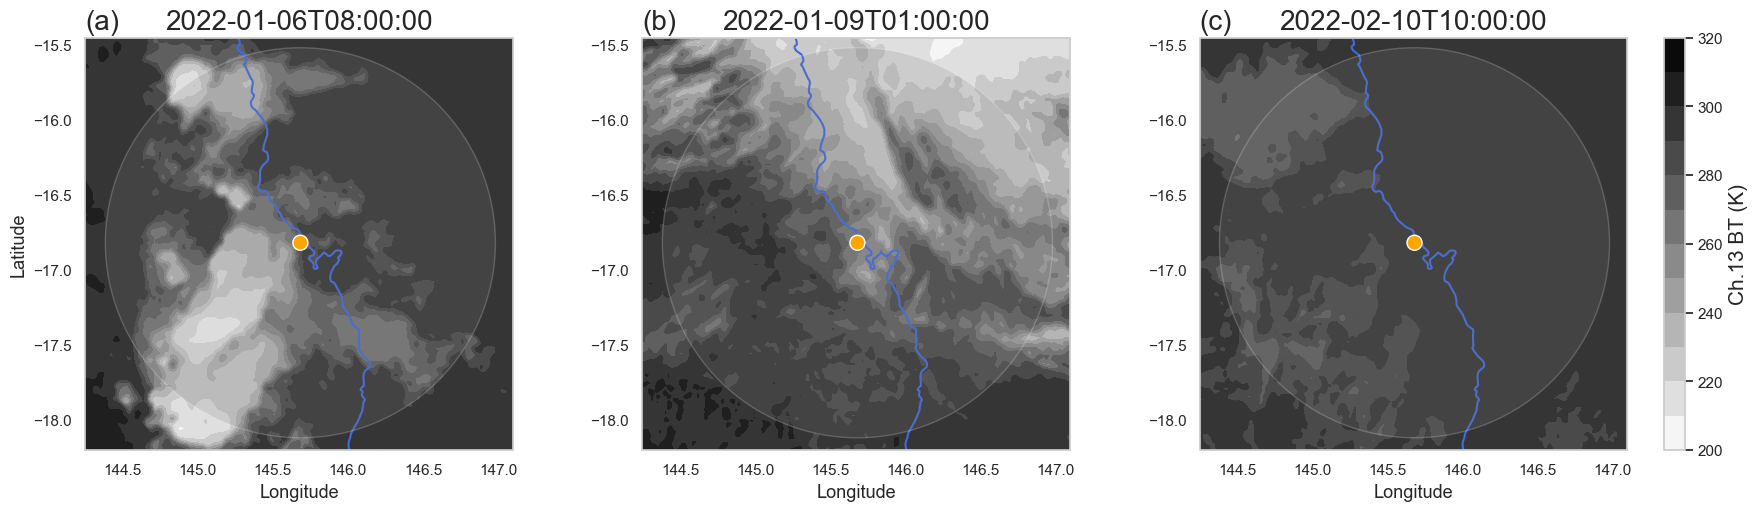

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

sns.set_theme(style="whitegrid")

proj = ccrs.PlateCarree()

fig, ax = plt.subplots(
    1, 3,
    figsize=(18, 5),
    subplot_kw={"projection": proj},
    constrained_layout=True
)
fig.patch.set_facecolor("white")

# Coordinates
x = case_study_jam.lon.values
y = case_study_jam.lat.values

snapshots = [
    "2022-01-06T08:00:00",
    "2022-01-09T01:00:00",
    "2022-02-10T10:00:00",
]

levels = np.arange(200, 330, 10)

for i, snapshot in enumerate(snapshots):
    z = case_study_jam.ch13BT.sel(time=snapshot)

    cf = ax[i].contourf(
        x, y, z,
        levels=levels,
        cmap="binary",
        transform=proj
    )

    # Map formatting
    ax[i].set_extent([144.25, 147.1, -18.2, -15.45], crs=proj)
    ax[i].coastlines("10m", color="royalblue", linewidth=1.5)

    ax[i].set_xticks(np.arange(144.5, 147.5, 0.5), crs=proj)
    ax[i].set_yticks(np.arange(-18, -15, 0.5), crs=proj)

    ax[i].set_xlabel("Longitude", fontsize=13)
    if i == 0:
        ax[i].set_ylabel("Latitude", fontsize=13)

    ax[i].set_title(f"({chr(97+i)})", loc="left", fontsize=20)
    ax[i].set_title(snapshot, fontsize=20)

    # Radar markers
    radar_site = mpatches.Circle(
        (145.683, -16.817), 0.05,
        fc="orange", transform=proj, zorder=5
    )
    radar_extent = mpatches.Circle(
        (145.683, -16.817), 1.3,
        fc="grey", alpha=0.2, transform=proj, zorder=4
    )

    ax[i].add_patch(radar_extent)
    ax[i].add_patch(radar_site)

# Shared colorbar
cbar = fig.colorbar(
    cf,
    ax=ax,
    orientation="vertical",
    fraction=0.03,   # thickness
    pad=0.02          # distance from plots
)
cbar.set_label("Ch.13 BT (K)", fontsize=15)
# plt.savefig('filename.png', dpi=300)

plt.show()


In [15]:
# convert UTC to LST
import datetime
import pytz
from datetime import datetime, timedelta
# Convert time to pandas datetime objects
time_values = pd.to_datetime(case_study_jam['time'].values,unit='ns')

# Define the longitude of the location (in degrees)
longitude = 145.6 # Cairns

# Convert nanoseconds to datetime objects in UTC
time_objects_utc = pd.to_datetime(time_values, unit='ns')

# Define the time zone for the location
local_timezone = pytz.timezone('Australia/Sydney')

# Convert UTC datetime objects to the local time zone
time_objects_local = time_objects_utc.tz_localize('UTC').tz_convert(local_timezone)

# Calculate the offset from UTC based on the longitude
# 4 minutes per degree of longitude from the prime meridian
longitude_offset = timedelta(minutes=(longitude / 360) * 60)

# Adjust the time to local solar time based on the longitude offset
time_objects_solar = time_objects_local - longitude_offset

# Format datetime objects as strings
time_strings_solar = time_objects_solar.strftime("%Y-%m-%d %H")

In [16]:
# update time in ds to local solar time
case_study_jam['time'] = time_strings_solar

In [90]:
# reindex satellite data, adding missing hours
sliced = slice('2022-01-04T23:00:00.000000000','2022-01-07T00:00:00.000000000')
y = case_study_jam.time.sel(time=sliced) 
# Convert time strings to datetime objects
time_objects = [datetime.strptime(time, "%Y-%m-%d %H") for time in y.values]
# Determine the range of hours to fill
min_time = min(time_objects)
max_time = max(time_objects)
# Generate a list of all hours between the min and max times
full_range = [min_time + timedelta(hours=x) for x in range((max_time - min_time).days * 24 + (max_time - min_time).seconds // 3600 + 1)]
# Convert datetime objects back to strings if needed
full_range_strings = [dt.strftime("%Y-%m-%d %H") for dt in full_range]

In [91]:
case_study_jam_reindexed = case_study_jam.reindex({"time": full_range_strings}, fill_value=np.nan)


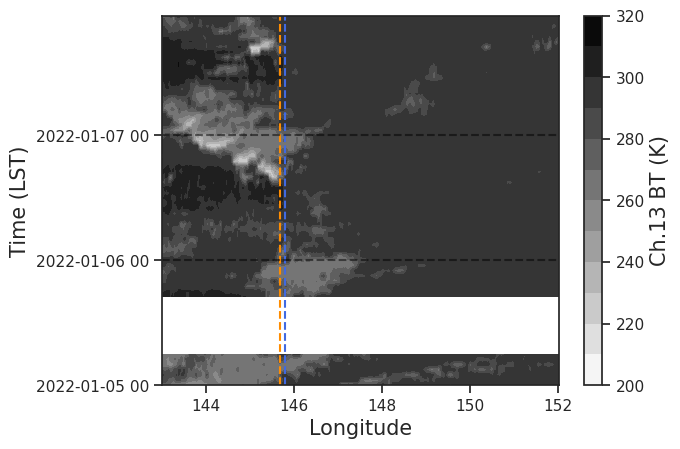

In [92]:
import seaborn as sns
sns.set_theme(style="ticks")

x = case_study_jam_reindexed.isel(time=0).lon.values
# sliced = slice('2022-01-04T23:00:00.000000000','2022-01-07T00:00:00.000000000')
y = case_study_jam_reindexed.time#.sel(time=sliced) #-16.817 #-19.4198
z = case_study_jam_reindexed.ch13BT.sel(lat=-16.817,method="nearest")#.sel(time=sliced) # latitude is for the central Townsville radar site location
levels= np.arange(200,330,10)
cf = plt.contourf(x,y,z,levels=levels,cmap="binary")
cb = plt.colorbar(cf)
cb.set_label('Ch.13 BT (K)',fontsize=15)
site_lon = []
coast = []
lengthoftime = 62
for i in np.arange(0,lengthoftime,1):
    site_lon.append(145.683) #towns:146.5509) 
    coast.append(145.8) # towns: 147.5)
plt.axvline(145.683,linestyle='--',color='darkorange')
plt.axvline(145.8,color='royalblue',linestyle='--')
# plt.title('Case Study 1',pad=15,fontsize=20)
plt.xlabel("Longitude",fontsize=15)
plt.ylabel('Time (LST)',fontsize=15)
yticks = np.arange(0,62,24)
plt.yticks(yticks)
plt.axhline(yticks[1],color="black",linestyle="--",alpha=0.5)
plt.axhline(yticks[2],color="black",linestyle="--",alpha=0.5);

### Radar reflectivity

In [5]:
def path_to_radar_ds(radar_site_no,variable):
    """
    List of yyyymm (year+month) with available radar data.
    For each yyyymm create a list of entire file paths to netCDF4 files.

    Parameters:
    - radar_site_no (str): Radar site number- BoM ID's for radar locations: Townsville=73, Cairns=19, and Willis Island=41 

    Returns:
    - list: list object of netCDF4 files
    """
    # list = ["202201","202202","202203","202204",]
    list = ["202201","202202","202203","202204","202101","202102","202103","202104"]#,"202001","202002","202003","202004","201901","201902","201903","201904",
        #   "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
         #  "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          # ] 
    files_list = []
    for i in list:
        fp = "/g/data/rq0/admin/level_2_decomissioned_fields/"+radar_site_no+"/"+variable+"/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list

# towns_radar_files = path_to_radar_ds("73","REFLECTIVITY")
# cairns_radar_files = path_to_radar_ds("19","REFLECTIVITY")
cairns_radar_files = path_to_radar_ds("19","RAINRATE")
# willis_radar_files = path_to_radar_ds("41","REFLECTIVITY")

In [ ]:
%%time
def open_radar(file_path,threshold): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        ds_mean = ds.rainrate.mean(dim='time')
        masked_beam_blockage = xr.where((ds_mean < threshold), np.zeros_like(ds_mean),np.ones_like(ds_mean))
        mask_nonvalid_points = ~ds.rainrate.mean(dim='time').isnull()
        mask = masked_beam_blockage.where(mask_nonvalid_points)
        return mask
# reflectivity = open_radar(cairns_radar_files,"reflectivity")
# rr = open_radar(cairns_radar_files,1.2)
rr_test = open_radar(cairns_radar_files,1)

In [6]:
%%time
def rr_mean(file_path): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        ds_mean = ds.rainrate.mean(dim='time')
        # masked = xr.where((ds_mean > threshold), np.zeros_like(ds_mean),np.ones_like(ds_mean))
        # mask = ds_mean.where(masked)
        return ds_mean
rrmean = rr_mean(cairns_radar_files)

CPU times: user 19.4 s, sys: 649 ms, total: 20.1 s
Wall time: 37.7 s


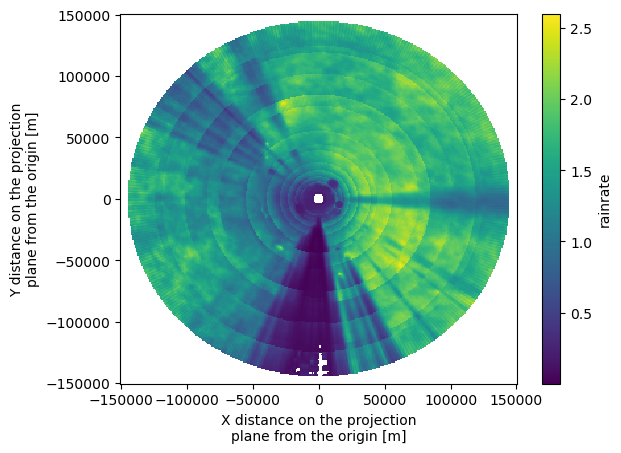

In [13]:
rrmean.plot()

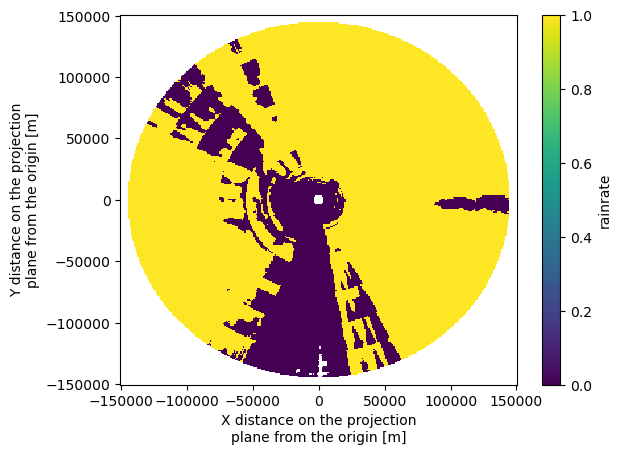

In [5]:
rr_test.plot()

In [7]:
%%time 
def open_radar(file_path,threshold): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        nan_to_zero = ds.rainrate.fillna(0)
        ds_mean = nan_to_zero.mean(dim='time')
        masked_beam_blockage = xr.where((ds_mean < threshold), np.zeros_like(ds_mean),np.ones_like(ds_mean))
        mask = masked_beam_blockage.where(masked_beam_blockage)
        return mask
# reflectivity = open_radar(cairns_radar_files,"reflectivity")
# rr = open_radar(cairns_radar_files,1.2)
rr_test = open_radar(cairns_radar_files,1.2)

CPU times: user 3min 30s, sys: 43.8 s, total: 4min 13s
Wall time: 2min 40s


In [12]:
rr_test==False

<xarray.DataArray 'rainrate' (y: 301, x: 301)> Size: 91kB
dask.array<eq, shape=(301, 301), dtype=bool, chunksize=(301, 301), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int32 1kB -150000 -149000 -148000 ... 148000 149000 150000
  * y        (y) int32 1kB -150000 -149000 -148000 ... 148000 149000 150000

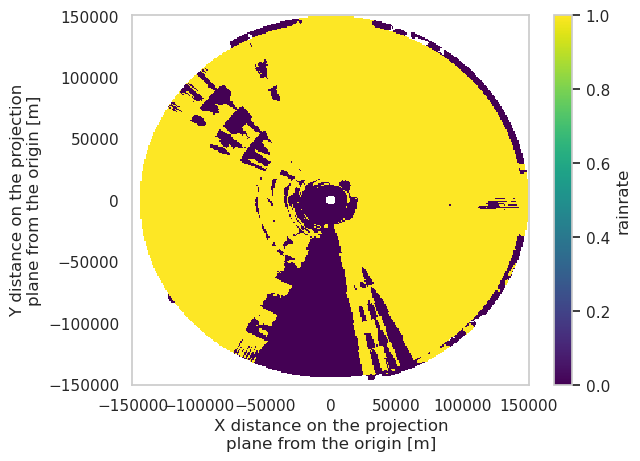

In [27]:
rr_test.plot()

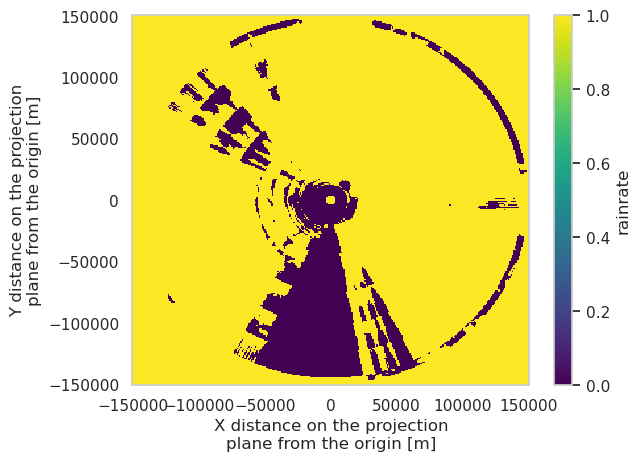

In [25]:
rr.plot()

In [8]:
%%time
def mask_rr(file_path,mask): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto").sel(time=slice('2022-01-05T10:00:00.000000000','2022-01-11T10:00:00.000000000')) as ds:
        masked_ds = ds.rainrate.where(mask)
        return masked_ds
masked_ds = mask_rr(cairns_radar_files,rr_test)

CPU times: user 8.4 s, sys: 73.8 ms, total: 8.47 s
Wall time: 8.52 s


In [9]:
%%time
def ds_not_masked(file_path): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto").sel(time=slice('2022-02-05T10:00:00.000000000','2022-02-11T10:00:00.000000000')) as ds:
        return ds
plotting = ds_not_masked(cairns_radar_files)

CPU times: user 8.24 s, sys: 57.2 ms, total: 8.3 s
Wall time: 8.35 s


CPU times: user 5min 20s, sys: 1min 6s, total: 6min 27s
Wall time: 4min 2s


Text(0.5, 0, 'Longitude')

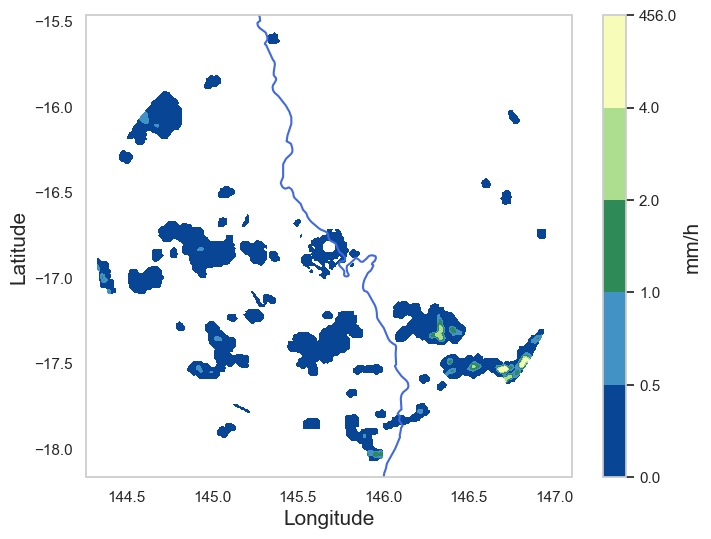

In [10]:
%%time
fig = plt.figure(figsize=(8,6))
fig.tight_layout()
fig.patch.set_facecolor('white')
sns.set_theme(style="whitegrid")
projPC = ccrs.PlateCarree()
ax = plt.subplot(1, 1, 1, projection=projPC)
time= "2022-02-10T10:00:00.000000000"
x = plotting.longitude.sel(time=time,method="nearest").values
y = plotting.latitude.sel(time=time,method="nearest").values
z = masked_ds.sel(time=time,method="nearest")
levels = [0,0.5,1,2,4,456]
cf_bb = ax.contourf(x,y,rr_test==False,levels=1,colors=["white","lightgrey"],alpha=0.5)
cf_nan = ax.contourf(x,y,np.isnan(rr_test),levels=1,colors=["white","lightgrey"],hatches=['/'],alpha=0.5)

colors = ['#084594', '#4292c6', 'seagreen','#addd8e', '#f7fcb9','pink','red']
cf = ax.contourf(x,y,z,levels=levels,colors=colors)
cb = plt.colorbar(cf,ax=ax)
cb.set_label("mm/h",fontsize=15)
xtick = np.arange(144.5,147.5,0.5)
ax.set_xticks(xtick)
ytick = np.arange(-18,-15,0.5)
ax.set_yticks(ytick)
ax.coastlines("10m",color="royalblue",linewidth=1.5)
ax.grid(None)
# ax.set_title(time[0:19])
ax.set_ylabel("Latitude",fontsize=15)
ax.set_xlabel("Longitude",fontsize=15)

In [11]:
time= "2022-02-10T10:00:00.000000000"

x = plotting.longitude.sel(time=time,method="nearest").values
y = plotting.latitude.sel(time=time,method="nearest").values
z = masked_ds.sel(time=time,method="nearest")

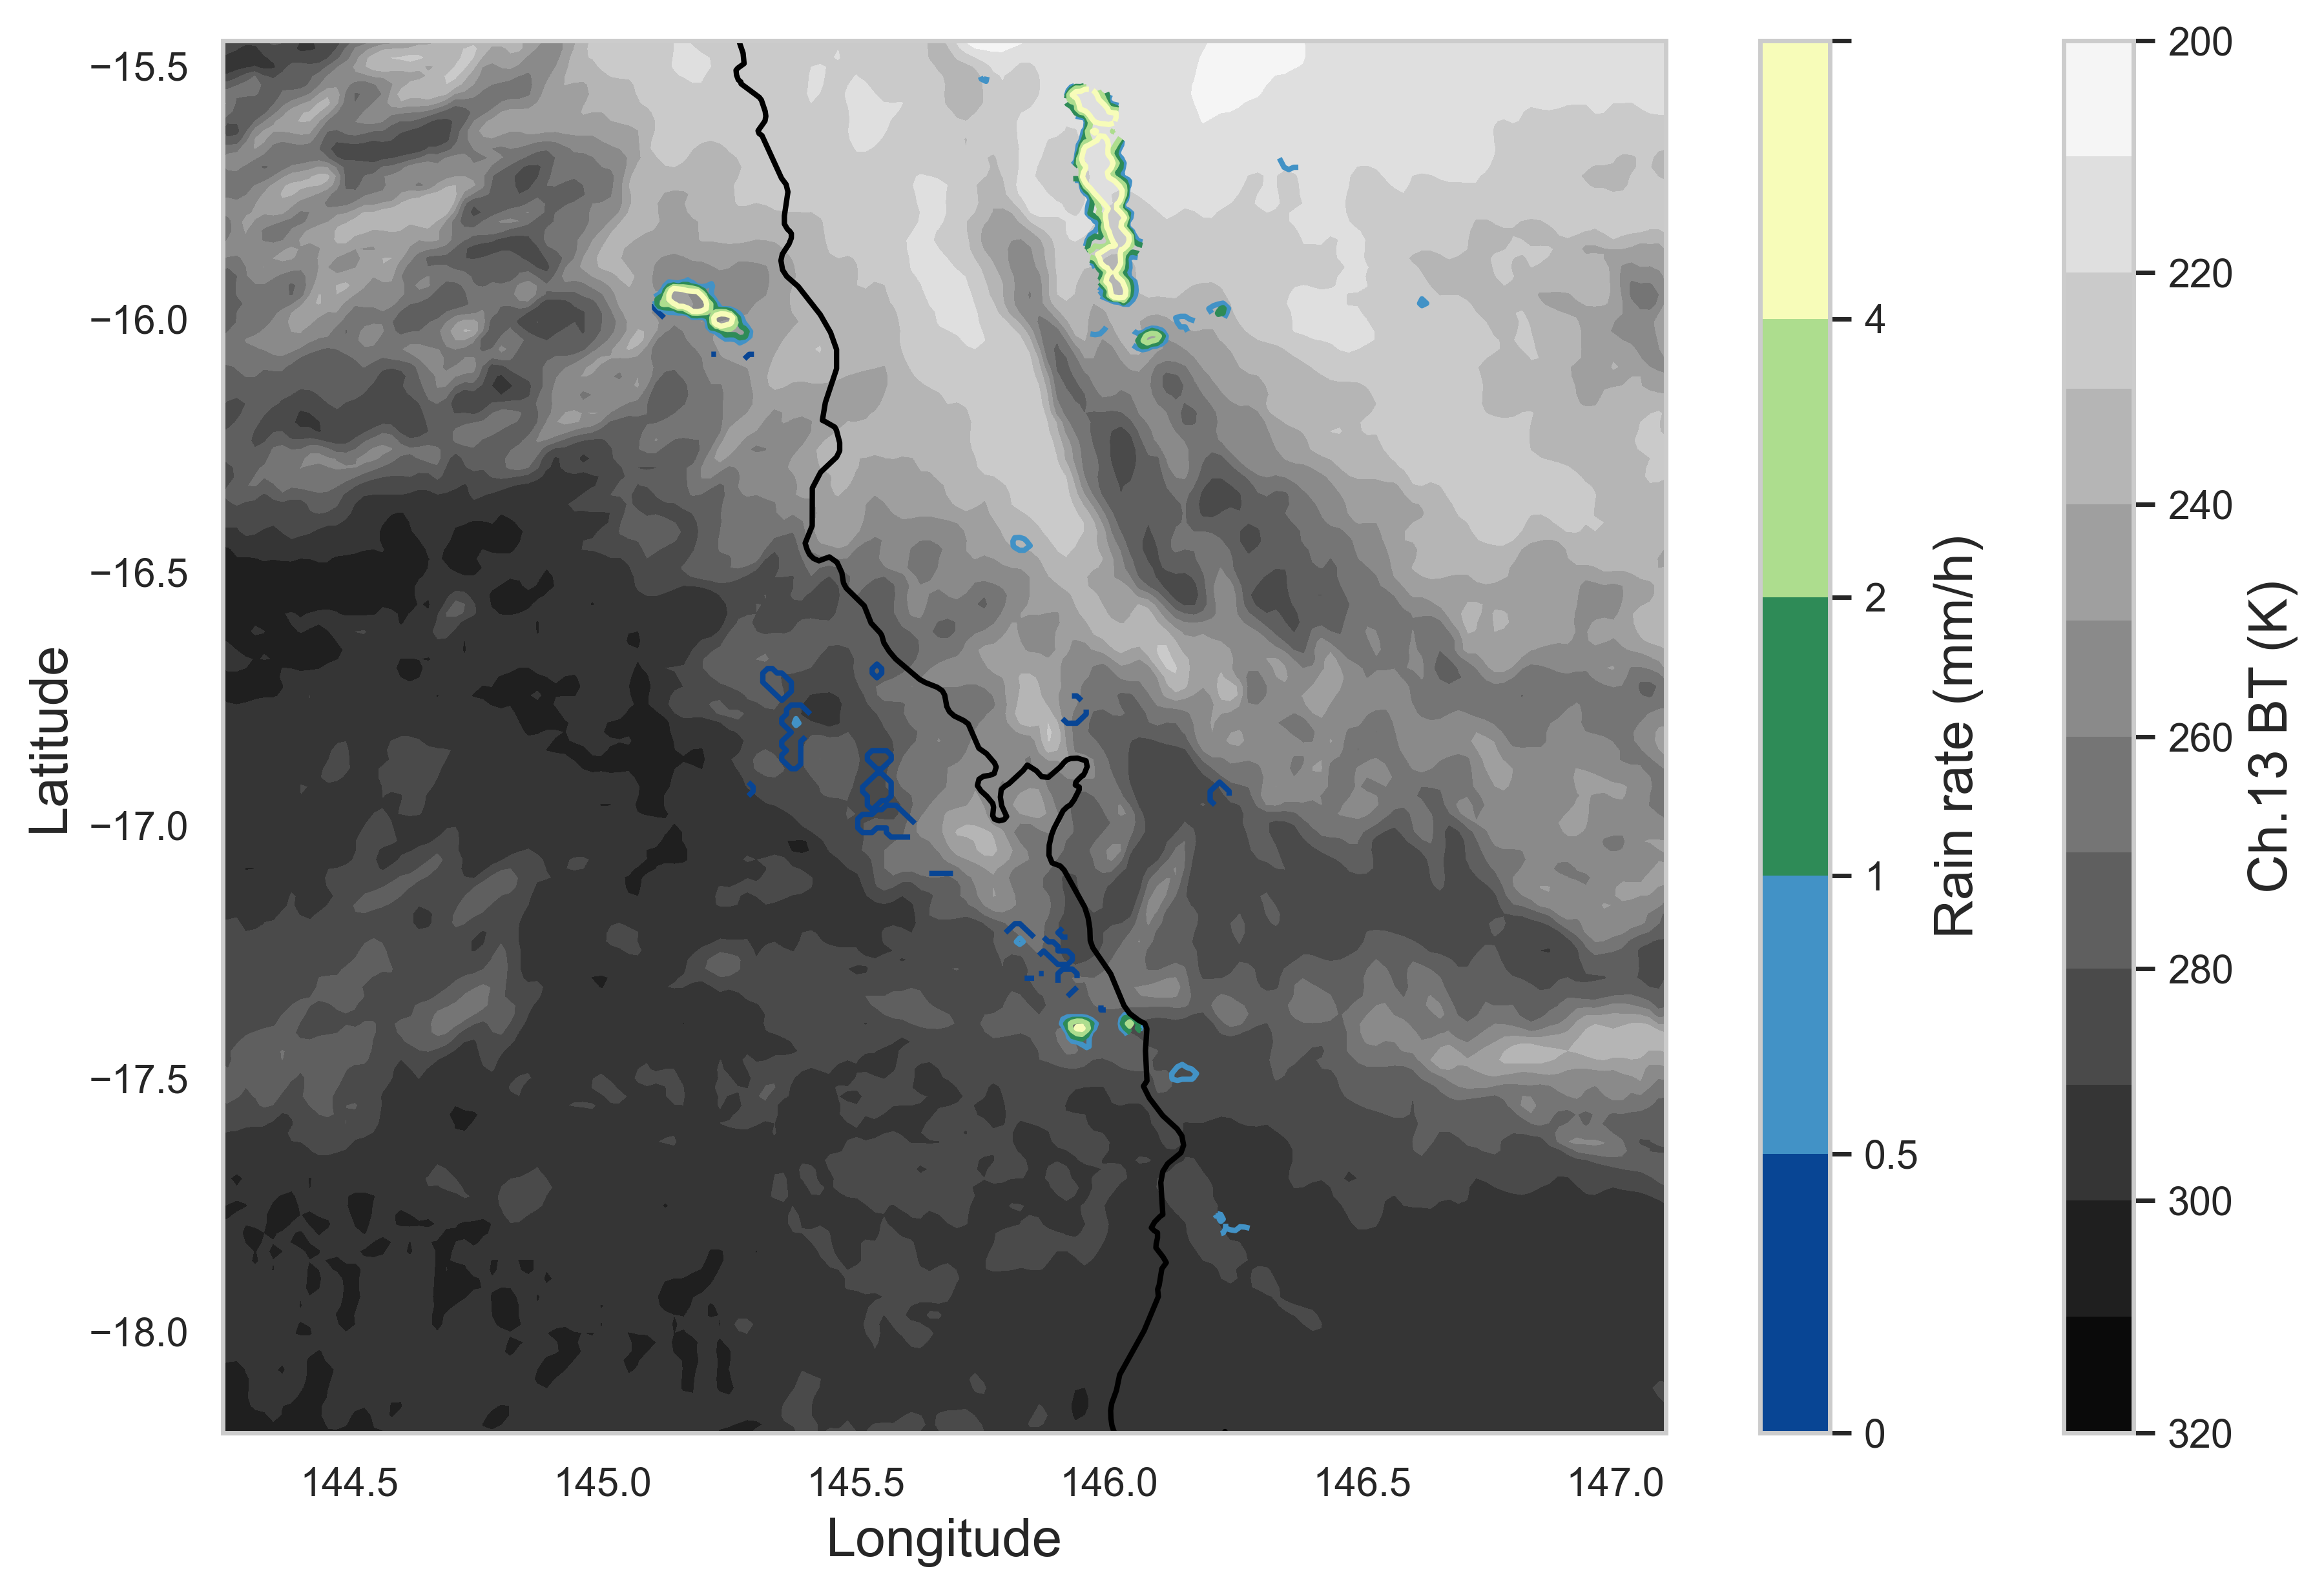

In [17]:
import seaborn as sns
fig = plt.figure(figsize=(10,7))
fig.tight_layout()
fig.patch.set_facecolor('white')
sns.set_theme(style="whitegrid")
projPC = ccrs.PlateCarree()
ax = plt.subplot(1, 1, 1, projection=projPC)
time= "2022-01-06T08:00:00" 
time="2022-02-10T10:00:00.000000000"
snapshot = '2022-01-06T08:00:00' # period 1
time = '2022-01-09T01:00:00' # period 2
# snapshot = '2022-02-10T10:00:00' # period 3

levels=np.arange(200,330,10)
x = case_study_jam.lon.values
y = case_study_jam.lat.values
z = case_study_jam.ch13BT.sel(time=time) 
levels=np.arange(200,330,10)
cf = ax.contourf(x,y,z,levels=levels,cmap="binary",zorder=2)
cb = plt.colorbar(cf,fraction=0.046, pad=0.01) 
cb.ax.invert_yaxis()
ax.set_xlim(144.5,147)
ax.set_ylim(-18,-15.5)
cb.set_label('Ch.13 BT (K)',fontsize=15)
xtick = np.arange(144.5,147.5,0.5)
ax.set_xlim(144.25,147.1)
ax.set_xticks(xtick)
ytick = np.arange(-18,-15,0.5)
ax.set_ylim(-18.2,-15.45)
ax.set_yticks(ytick)

x = plotting.longitude.sel(time=time,method="nearest").values
y = plotting.latitude.sel(time=time,method="nearest").values
z = masked_ds.sel(time=time,method="nearest")
levels = [0,0.5,1,2,4,456]
colors = ['#084594', '#4292c6', 'seagreen','#addd8e', '#f7fcb9','pink','red']
c = ax.contour(x,y,z,levels=levels,colors=colors,zorder=2)
cf = ax.contourf(x,y,z,levels=levels,colors=colors,zorder=1)
cb = plt.colorbar(cf,ax=ax)
cb.set_label("Rain rate (mm/h)",fontsize=15)
cb.set_ticklabels(["0","0.5","1","2","4",""])
xtick = np.arange(144.5,147.5,0.5)
ax.set_xticks(xtick)
ytick = np.arange(-18,-15,0.5)
ax.set_yticks(ytick)

ax.coastlines("10m",color="black",linewidth=1.5,zorder=2)
ax.grid(None)
# ax.set_title(time[0:19])
ax.set_ylabel("Latitude",fontsize=15)
ax.set_xlabel("Longitude",fontsize=15)
# plt.savefig('filename.png', dpi=300)
plt.rcParams['figure.dpi'] = 400